In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pylab as plt 
from scipy.stats import norm
import yfinance as yf 
from itertools import accumulate

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    benchmark = port_ret['Benchmark']
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D', benchmark = benchmark).transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M',
                                                    benchmark = benchmark).transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino', 'IR'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Active Risk'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",'Active Risk': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}",'IR': "{:.2f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics


def port_eval(port, freq = 'D', benchmark = None):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    

    rel_return = port_ret.subtract(benchmark, axis = 0) +1

    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(252),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(252/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(12),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(12/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                float(active_risk.iloc[0]),float(IR.iloc[0])]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'Active Risk',
                         'IR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 




def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [3]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr

## Momentum Backtest

To do
- add volatility
- add fundamental data
- try different things
    - Acceleration
- Use daily data 
- Add rebalancing options, daily, monthly...

In [27]:
price_df = pd.read_csv('data/VQ_data.csv')
price_df['d'] = pd.to_datetime(price_df['d'])
price_df = price_df.set_index(['d', 'insID'])

In [28]:
index_df = pd.read_csv('data/OMX_GI.csv')
index_df['d'] = pd.to_datetime(index_df['d'])
index_df = index_df.set_index(['d'])
index_df = pd.DataFrame(index_df['c'])
index_df = index_df.resample('m').last()
index_df = index_df.pct_change()
index_df = index_df.shift(-1)

In [29]:
# USE ONLY DATA WHERE WE HAVE EA RET
close_df = price_df.loc[price_df['PE'].first_valid_index():,]

data_df =close_df.groupby([close_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()

# get return, use adjusted price for dividends
data_df['ret'] = data_df['adj_c'].groupby(level='insID').pct_change(1).shift(-1)


In [30]:
ml_pred_df = pd.read_csv('stat_analysis/RF_pred.csv')
ml_pred_df['d'] = pd.to_datetime(ml_pred_df['d'])
ml_pred_df = ml_pred_df.set_index(['d', 'insID'])

data_df = data_df.join(ml_pred_df, on=['d','insID'],how='left')
data_df['RF_pred'] = data_df['RF_pred'].groupby(level='insID').ffill()

In [31]:
data_df['market'].unique()

array([None, 'Large_Cap', 'Small_Cap', 'Mid_Cap', 'First_North'],
      dtype=object)

### SETTINGS FOR BACKTEST

In [32]:
min_MCAP = 500
min_liq = 0.5
not_secors = ['finance_RE'] #'finance_RE'
not_markets = [None]

data_df=data_df[ ~data_df['sector'].isin(not_secors)]
data_df=data_df[ ~data_df['market'].isin(not_markets)]
data_df = data_df[data_df['MCAP']>min_MCAP]
#data_df = data_df[data_df['MA50_VOL']>min_liq]

### RANKS

In [33]:
### Momentum Ranks

### ALPHA & BETA

data_df['alpha_rank'] = data_df['alpha'].groupby(level='d').rank(ascending=False)
data_df['beta_rank'] = data_df['beta'].groupby(level='d').rank(ascending=False)
data_df['sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=False)
data_df['res_mom12_rank'] = data_df['res_mom12'].groupby(level='d').rank(ascending=False)
data_df['ido_mom12_rank'] = data_df['ido_mom12'].groupby(level='d').rank(ascending=False)

data_df['std_alpha_rank'] = data_df['std_alpha'].groupby(level='d').rank(ascending=False)
data_df['VAR_mom_rank'] = data_df['VAR_mom'].groupby(level='d').rank(ascending=False)



#rank based on 12 month mom
data_df['mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=False)
data_df['mom6_rank'] = data_df['mom6'].groupby(level='d').rank(ascending=False)
data_df['mom3_rank'] = data_df['mom3'].groupby(level='d').rank(ascending=False)
data_df['mom1_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=False)



data_df['2y_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['12m_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['6m_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['3m_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['1m_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=False, method = 'first')


data_df['EMA_32_96_rank'] = data_df['EMA_32_96'].groupby(level='d').rank(ascending=False)
data_df['EMA_96_288_rank'] = data_df['EMA_96_288'].groupby(level='d').rank(ascending=False)




data_df['ST_rev_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=True)

data_df['adj_mom_rank'] = data_df['adj_mom'].groupby(level='d').rank(ascending=False)
data_df['EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=False)
data_df['EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=False)
data_df['accel_rank'] = data_df['acceleration'].groupby(level='d').rank(ascending=False)
data_df['volatility_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=True)
data_df['RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=False)
data_df['SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=False)
data_df['EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=False)
data_df['rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=False)
data_df['EPS_a_rank'] = data_df['EPS_acceleration'].groupby(level='d').rank(ascending=False)



### COMPOSITE RANKS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(comb_mom = x.mom12_rank + x.mom6_rank +x.mom3_rank)) #x.mom12_rank + x.mom6_rank +x.mom3_rank +

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_MOM = x.comb_mom +x.EAR_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_std_MOM = x.comb_mom +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod1_comb_mom = x.mom12_rank +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod2_comb_mom = x.mom12_rank + x.mom6_rank  +x.EAR_std_rank ))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod3_comb_mom = x.mom12_rank + x.mom6_rank  +x.EAR_std_rank +x.res_mom12_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(focus_mom = x.EAR_std_rank + x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_vol = x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(fund_mom = x.SUE_rank + x.RSURP_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_SUE = x.SUE_rank +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(INT_MOM = x['EMA_96_288_rank'] +x['EMA_32_96_rank'] ))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EMA = x['12m_high_rank'] +x.EAR_std_rank + x.mom12_rank ))

data_df['comb_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mom_vol_rank'] = data_df['mom_vol'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['EAR_SUE_rank'] = data_df['EAR_SUE'].groupby(level='d').rank(ascending=True)  #should be True
data_df['INT_MOM_rank'] = data_df['INT_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['EMA_rank'] = data_df['EMA'].groupby(level='d').rank(ascending=True)  #should be True



data_df['mod1_comb_mom_rank'] = data_df['mod1_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod2_comb_mom_rank'] = data_df['mod2_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod3_comb_mom_rank'] = data_df['mod3_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True






data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom = x.fund_mom_rank + x.ear_mom_rank))
data_df['twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom_alt = x.fund_mom_rank + x.comb_mom_rank +x.EAR_std_rank ))
data_df['twin_mom_alt_rank'] = data_df['twin_mom_alt'].groupby(level='d').rank(ascending=True)  #should be True





In [34]:
##VALUATION MEASURES

#### SET NEGATIVE MULTIPLES TO MAX, MAKES NO SENSE OTHERWISE

for ratio in ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']:
    data_df.loc[data_df[ratio]< 0,ratio] = data_df[ratio].max()



data_df['ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=True)
data_df['PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=True) #low is good
data_df['PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVEBIT_rank'] = data_df['EVEBIT'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVFCF_rank'] = data_df['EVFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['PS_rank'] = data_df['PS'].groupby(level='d').rank(ascending=True) #low is good
data_df['PFCF_rank'] = data_df['PFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['DIVY_rank'] = data_df['DIV_Y'].groupby(level='d').rank(ascending=False) #high is good


#### VALUE COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.PFCF_rank ))

data_df['VC_rank'] = data_df['VC'].groupby(level='d').rank(ascending=True)  #should be True


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC2 = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.ag_rank))

data_df['VC2_rank'] = data_df['VC2'].groupby(level='d').rank(ascending=True)  #should be True


In [35]:
### PROFITABILITY MEASURES
data_df['GPA_rank'] = data_df['GPA'].groupby(level='d').rank(ascending=False) #high is good
data_df['GPA_chg_rank'] = data_df['GPA_chg'].groupby(level='d').rank(ascending=False) #high is good

data_df['ROIC_rank'] = data_df['ROIC'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_rank'] = data_df['ROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_chg_rank'] = data_df['ROE_chg'].groupby(level='d').rank(ascending=False) #high is good
data_df['AT_rank'] = data_df['AT'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROA_rank'] = data_df['ROA'].groupby(level='d').rank(ascending=False) #high is good
data_df['FCFROE_rank'] = data_df['FCFROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['Gross_margin_rank'] = data_df['Gross_margin'].groupby(level='d').rank(ascending=False) #high is good



#### QUALITY COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QC = x.GPA_rank + x.ROIC_rank + x.ROE_rank + x.AT_rank + x.FCFROE_rank))

data_df['QC_rank'] = data_df['QC'].groupby(level='d').rank(ascending=True)  #should be True



In [36]:
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VQ = x.VC_rank + x.QC_rank ))#VQ
data_df['VQ_rank'] = data_df['VQ'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QM = x.GPA_rank + x.ear_std_mom_rank ))#VQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod_QM = x.GPA_rank + x.ear_std_mom_rank + x.SUE_rank))#VQ




### COMPOSITE of COMPOSITE METRCIS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VM = x.VC_rank + x.ear_std_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ = x.VC_rank + x.QC_rank + x.ear_std_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(zhang = x.ag_rank + x.GPA_rank))#VMQ


data_df['VMQ_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod_QM_rank'] = data_df['mod_QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=True)  #should be True

In [37]:
### ANTI STRATEGIES
data_df['neg_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)

data_df['bad_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['dog_shit_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=True)
data_df['evil_twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=False)  #should be True

data_df['bad_ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=False)  #should be True


########

data_df['2y_low_rank'] = data_df['low_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_low_rank'] = data_df['low_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_low_rank'] = data_df['low_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_low_rank'] = data_df['low_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_low_rank'] = data_df['low_1m'].groupby(level='d').rank(ascending=True, method = 'first')


#Broken highs

data_df['2y_broken_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_broken_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_broken_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_broken_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_broken_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=True, method = 'first')



data_df['bad_EMA_32_96_rank'] = data_df['EMA_32_96'].groupby(level='d').rank(ascending=True)
data_df['bad_EMA_96_288_rank'] = data_df['EMA_96_288'].groupby(level='d').rank(ascending=True)
data_df['bad_EMA_rank'] = data_df['EMA'].groupby(level='d').rank(ascending=False)  #should be True



#################
data_df['bad_QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['high_vol_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=False)



#########
data_df['low_alpha_rank'] = data_df['alpha'].groupby(level='d').rank(ascending=True)
data_df['low_beta_rank'] = data_df['beta'].groupby(level='d').rank(ascending=True)
data_df['low_sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=True)
data_df['low_res_mom12_rank'] = data_df['res_mom12'].groupby(level='d').rank(ascending=True)


data_df['low_mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=True)


In [38]:
### MISC STRATEGIES
#data_df['MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=False)
#data_df['anti_MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=True)

### ML STRATEGY
data_df['ML_rank'] = data_df['RF_pred'].groupby(level='d').rank(ascending=False, method = 'first').dropna()  #should be True
data_df['alt_ML_rank'] = data_df['RF_pred'].groupby(level='d').rank(ascending=True, method = 'first').dropna()  #should be True

# SKEW
data_df['low_skew_rank'] = data_df['skew'].groupby(level='d').rank(ascending=True)
data_df['high_skew_rank'] = data_df['skew'].groupby(level='d').rank(ascending=False)


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_skew = x.ear_std_mom_rank +x.low_skew_rank ))

data_df['mom_skew_rank'] = data_df['mom_skew'].groupby(level='d').rank(ascending=True)  #should be True


### Set up back test

- equal weight
- no capital filter
- for loop for different ranks

In [39]:
value_strats_list = ['ag_rank', 'PE_rank','PB_rank','EVEBIT_rank', 'EVFCF_rank', 'PS_rank', 
               'PFCF_rank','DIVY_rank','VC_rank', 'VC2_rank']

quality_strats_list = ['Gross_margin_rank','GPA_rank', 'ROIC_rank', 'ROE_rank', 'AT_rank', 'ROA_rank', 'FCFROE_rank', 'QC_rank']

composite_strats_list = ['QC_rank', 'VC_rank', 'ear_std_mom_rank', 'VM_rank', 'QM_rank','VQ_rank', 'VMQ_rank', 'twin_mom_rank', 'mod_QM_rank']

momentum_strats_list = ['EAR_std_rank', 'comb_mom_rank','ear_std_mom_rank', 'focus_mom_rank', 'mod3_comb_mom_rank']

misc_strats = ['SUE_rank', 'RSURP_rank', 'fund_mom_rank', 'twin_mom_rank', 'twin_mom_alt_rank', 'EAR_SUE_rank']


mom_ls_strats = ['ear_std_mom_rank', 'comb_mom_rank', 'bad_EAR_std_rank', 'neg_mom_rank', 'bad_mom_rank', 'EAR_std_rank']

bad_strats = ['bad_QM_rank', 'bad_mom_rank','dog_shit_rank' ]

fund_mom = ['SUE_rank', 'RSURP_rank', 'EPS_g_rank', 'rev_g_rank', 'EPS_a_rank']



################

best_strats = ['SUE_rank', 'VMQ_rank', 'ear_std_mom_rank', 'QM_rank', 'focus_mom_rank']

high_low_strats = ['12m_low_rank', '6m_low_rank', '12m_high_rank', '6m_high_rank', '3m_low_rank', '3m_high_rank']

highs = ['2y_high_rank','12m_high_rank', '6m_high_rank', '3m_high_rank', '1m_high_rank' ]

broken_highs = ['2y_broken_high_rank','12m_broken_high_rank',
                '6m_broken_high_rank', '3m_broken_high_rank', '1m_broken_high_rank' ]

lows = ['2y_low_rank','12m_low_rank', '6m_low_rank', '3m_low_rank', '1m_low_rank' ]


EMA_strats = ['EMA_32_96_rank','EMA_96_288_rank', 'bad_EMA_32_96_rank','bad_EMA_96_288_rank', 'EMA_rank',
             'bad_EMA_rank']





In [72]:
top_n =15
rebal_period = 3

strat_df = pd.DataFrame()
strats_test = ['alpha_rank', 'sharpe_rank', 'res_mom12_rank','ido_mom12_rank' ,'mom12_rank', 'std_alpha_rank',
              'VAR_mom_rank', 'ML_rank']
for strat in strats_test:
    
    rank_tmp = data_df.unstack(level = 'insID')[strat]
    rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
    ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
    
    rank_df_empt= rank_tmp.copy()
    rank_df_empt[:] = np.nan
    for col in rank_tmp.columns:
        rank_df_empt.loc[::rebal_period,col] = np.where(rank_tmp[::rebal_period][col]<=top_n, 1, 0)
    
    filled_rank_df = rank_df_empt.fillna(method="ffill")
    
    ret_tmp=np.multiply(filled_rank_df,ret_df)
    ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
    ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
    ret_neu_tmp.columns = [strat]

    strat_df = pd.concat([strat_df, ret_neu_tmp],axis = 1, sort=False)

In [73]:
strat_df = strat_df.dropna()
result = pd.concat([strat_df, index_df],axis = 1, sort=False)
result.columns = strat_df.columns.to_list() + ["Benchmark"]
result = result.dropna()
result = result[:-1]

In [74]:
#result['SISU'] = 0.5*result['VMQ_rank'] + 0.5*result['ear_std_mom_rank']
#result['LS_QM'] = 1.3*result['QM_rank'] - 0.3*result['bad_QM_rank']
#result['LS_EAR_MOM'] = 1*result['ear_std_mom_rank'] - 0.3*result['bad_mom_rank']
#result['LS_BREAK'] = 1*result['12m_high_rank'] - 0.3*result['12m_low_rank']

In [75]:
result_cum = result+1
result_cum = result_cum.cumprod()
result_cum = result_cum.astype('float64')

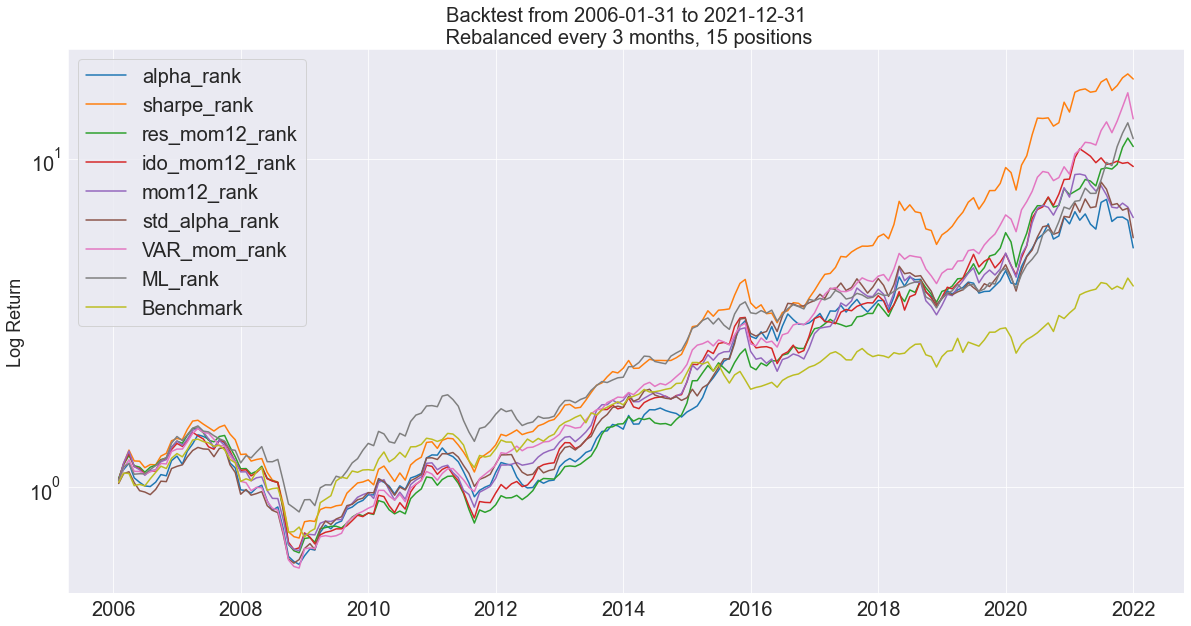

In [76]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end) +
          "\n Rebalanced every " + str(rebal_period) + " months, " + str(top_n) + " positions", fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [78]:
strategy_evaluation(result_cum, result_cum.columns, freq = 'M')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,Active Risk,IR
alpha_rank,10.6%,21.7%,0.5,0.7,-60.0%,0.18,18.5%,0.04
sharpe_rank,19.2%,20.1%,0.9,1.4,-56.0%,0.34,17.0%,0.50
res_mom12_rank,15.6%,19.7%,0.8,1.0,-58.0%,0.27,15.5%,0.35
ido_mom12_rank,14.7%,21.4%,0.7,1.0,-56.0%,0.26,17.7%,0.26
mom12_rank,12.2%,21.5%,0.6,0.9,-58.0%,0.21,18.3%,0.12
std_alpha_rank,11.4%,20.9%,0.5,0.8,-56.0%,0.20,17.5%,0.08
VAR_mom_rank,17.2%,18.7%,0.9,1.2,-62.0%,0.28,14.9%,0.46
ML_rank,16.1%,17.6%,0.9,1.3,-45.0%,0.36,12.7%,0.47
Benchmark,9.0%,16.7%,0.5,0.6,-50.0%,0.18,0.0%,0.00


In [59]:
correlation_map(result_cum)


,alpha_rank,sharpe_rank,res_mom12_rank,ido_mom12_rank,mom12_rank,std_alpha_rank,VAR_mom_rank,ML_rank,Benchmark
alpha_rank,1.00,0.69,0.64,0.64,0.71,0.89,0.68,0.65,0.52
sharpe_rank,0.69,1.00,0.79,0.78,0.90,0.62,0.85,0.65,0.53
res_mom12_rank,0.64,0.79,1.00,0.79,0.75,0.62,0.81,0.74,0.61
ido_mom12_rank,0.64,0.78,0.79,1.00,0.84,0.60,0.69,0.60,0.55
mom12_rank,0.71,0.90,0.75,0.84,1.00,0.65,0.76,0.57,0.48
std_alpha_rank,0.89,0.62,0.62,0.60,0.65,1.00,0.65,0.64,0.49
VAR_mom_rank,0.68,0.85,0.81,0.69,0.76,0.65,1.00,0.73,0.60
ML_rank,0.65,0.65,0.74,0.60,0.57,0.64,0.73,1.00,0.70
Benchmark,0.52,0.53,0.61,0.55,0.48,0.49,0.60,0.70,1.00


In [84]:
#Bootstarp returns

n_sim = 100
boot_leng = 25 * 12

bootstarp_strats = pd.DataFrame()

for strats in result.columns:
    cagr_list = []
    
    for i in range(n_sim):
        ret_sample = result[strats].sample(n=boot_leng, replace=True)
        cagr_sample = (ret_sample+1).cumprod()
        cagr_tmp = cagr_sample.tail(1).values[0]
        cagr_tmp = cagr_tmp**(1/25) - 1
        cagr_list.append(cagr_tmp)

    bootstarp_strats.loc[:,strats] = cagr_list 
    

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

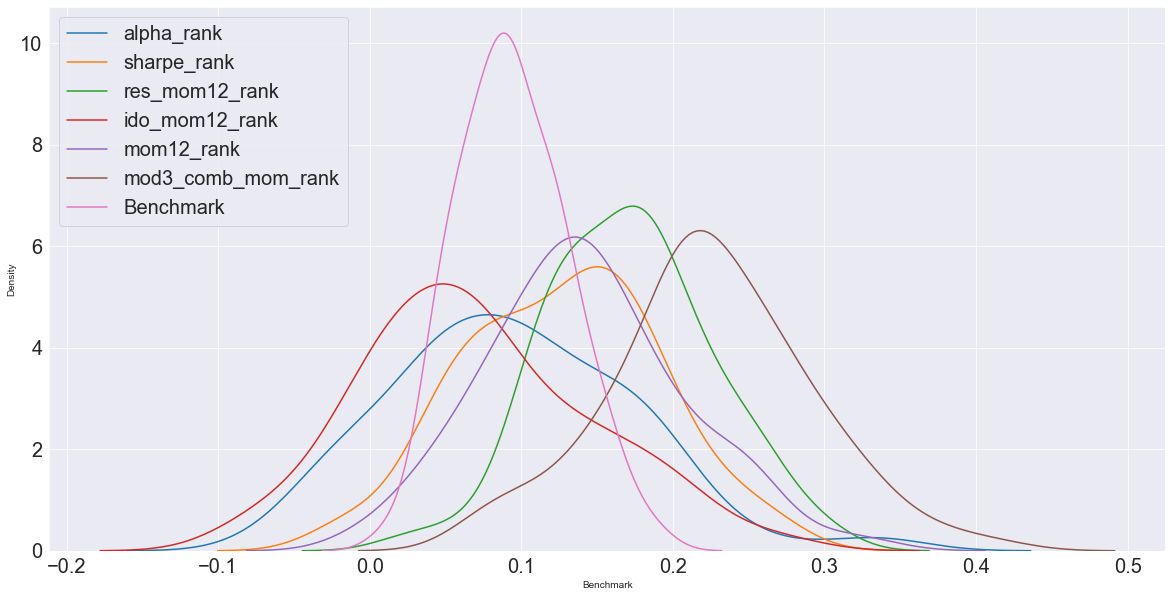

In [85]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in bootstarp_strats.columns:
    #plt.hist(bootstarp_strats[i], label = i, bins = 100);
    sns.distplot(bootstarp_strats[i], label = i, hist = False);
    
plt.legend(loc=2, prop={'size': 20});

In [86]:
#Calculate log returns
result_log = np.log(result_cum) - np.log(result_cum.shift(1))
result_log = result_log.dropna()

#Calculate relative returns
rel_result = result_log.subtract((pd.Series(result['Benchmark'])), axis = 0).dropna()
rel_result = rel_result.drop(['Benchmark'], axis= 1)

#calculate Max DD
Roll_Max = (np.exp(rel_result)).cumprod().cummax()
Daily_Drawdown = (np.exp(rel_result)).cumprod()/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()
Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)


# the t-value is easily computed with numpy
t = (np.mean(rel_result))/(rel_result.std(ddof=1)/np.sqrt(len(rel_result)))



# DRAWDOWN LENGTH
#xs = rel_result.cumsum().dropna()
xs = rel_result.cumsum().dropna()
cum_drawdown = np.maximum.accumulate(xs) - xs
time_df = pd.DataFrame(cum_drawdown.apply(np.argmax), columns=['end'])
time_df['start'] = np.nan

for col in xs.columns:
    tmp_idx = xs.index[time_df.loc[col,'end']]
    time_df.loc[col,'start'] = np.argmax(xs.loc[:tmp_idx,col])
time_df['L'] = time_df['end'] - time_df['start']


#CREATE DASHBOARD
rel_perf_df = pd.DataFrame(columns = Max_Daily_Drawdown.columns, index=['Max rel. DD','Longest rel. DD', 't-value vs. index'])
rel_perf_df.loc['t-value vs. index',:] = round(t,2)
rel_perf_df.loc['Max rel. DD',:] = Max_Daily_Drawdown.values
#rel_perf_df.loc['Longest rel. DD', :] = time_df['L'].values


In [87]:
rel_perf_df

,alpha_rank,sharpe_rank,res_mom12_rank,ido_mom12_rank,mom12_rank,mod3_comb_mom_rank
Max rel. DD,-0.71,-0.48,-0.37,-0.74,-0.43,-0.38
Longest rel. DD,NaN,NaN,NaN,NaN,NaN,NaN
t-value vs. index,-0.36,0.24,0.97,-0.38,0.46,1.55


In [73]:
#test = result_log.cumsum()['ear_std_mom_rank']
test = rel_result.cumsum()['mod3_comb_mom_rank']

#calculate Max DD
Roll_Max = test.cummax()
Daily_Drawdown = test - Roll_Max
Max_Daily_Drawdown = Daily_Drawdown.cummin()
Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)


plt.figure(figsize=(20,10));
i = np.argmax(np.maximum.accumulate(test) - test) # end of the period
j = np.argmax(test[:i]) # start of period
plt.plot(test);
plt.plot([test.index[i], test.index[j]], [test[i], test[j]], 'X', color='Red', markersize=10);

print("Max Length of DD:", i-j)
print("Max DD:", Max_Daily_Drawdown[0])

KeyError: 'mod3_comb_mom_rank'

In [79]:
result_by_year = (result+1).groupby(result.index.year).prod() - 1
result_by_month = (result+1).groupby(result.index.month).mean() - 1

In [80]:
result_by_year

,ML_rank,alt_ML_rank,ear_std_mom_rank,focus_mom_rank,res_mom12_rank,mod3_comb_mom_rank,Benchmark
d,,,,,,,
2006,0.461325,0.015240,0.465127,0.307100,0.378150,0.626997,0.267139
2007,-0.134762,-0.258800,-0.058247,0.108291,-0.015746,0.029408,-0.177036
2008,-0.212771,-0.577857,-0.355502,-0.269803,-0.241237,-0.337199,-0.322967
2009,0.778874,1.017501,0.240866,0.093397,0.223505,0.375110,0.603420
2010,0.432112,0.029000,0.191797,0.251772,0.329933,0.269108,0.237346
2011,0.012524,-0.270365,-0.116379,-0.061945,-0.133117,-0.094623,-0.065749
2012,0.159953,0.172283,0.211630,0.274246,0.307606,0.272407,0.173703
2013,0.359603,0.038026,0.482287,0.223556,0.186710,0.343230,0.160112
2014,0.335539,-0.128291,0.339045,0.259857,0.212332,0.160844,0.251152


## Performance by rebalancing date

- measure by sharpe ratio

In [31]:
rebal_diff_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))
turnover_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))


for strat in strats_test:
    
    for rebal in rebal_diff_df.columns:
    
        rank_tmp = data_df.unstack(level = 'insID')[strat]
        rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
        ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
 
        sharpe_list = []    
        rank_df_empt= rank_tmp.copy()
        rank_df_empt[:] = np.nan
        for col in rank_tmp.columns:
            rank_df_empt.loc[::rebal,col] = np.where(rank_tmp[::rebal][col]<=top_n, 1, 0)
    
        filled_rank_df = rank_df_empt.fillna(method="ffill")
    
        ret_tmp=np.multiply(filled_rank_df,ret_df)
        ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
        ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
        ret_neu_tmp.columns = [strat]
        sharpe_tmp = (ret_neu_tmp.mean()*12)/(ret_neu_tmp.std()*np.sqrt(12))
        turnover = filled_rank_df.diff().abs().sum().sum()
        years = len(rank_df_empt)/12
        turn_year = (turnover/top_n)/years
        
        
        turnover_df.loc[strat,rebal] = turn_year/2
        rebal_diff_df.loc[strat,rebal] = sharpe_tmp[0]
        

In [32]:
rebal_diff_df

,1,2,3,4,5,6,7,8,9,10,11,12
ML_rank,1.380257,1.382615,1.255929,1.232069,1.120149,1.281564,1.273501,1.128004,1.257238,1.051992,1.054673,1.059621
alt_ML_rank,0.008275,0.078642,0.123992,0.062951,0.106971,0.141246,0.113612,0.246437,0.309933,0.016208,0.212097,0.253837
ear_std_mom_rank,1.190834,1.208116,1.139353,1.222843,1.195481,1.037018,0.89219,0.944083,0.940025,1.139703,1.087816,1.021608
focus_mom_rank,1.296896,1.276111,1.296006,1.26446,1.320262,1.312528,1.265085,1.295236,1.302093,1.278179,1.313091,1.365799
res_mom12_rank,0.887427,0.761302,0.785998,0.918854,0.820202,0.840379,0.82414,0.867811,0.910005,0.954856,0.866167,1.117073
mod3_comb_mom_rank,0.943662,0.965912,0.914828,1.009688,1.048805,0.942935,0.634231,0.965914,0.78061,0.757019,1.01375,0.869095


In [33]:
turnover_df

,1,2,3,4,5,6,7,8,9,10,11,12
ML_rank,6.178166,3.89345,2.824454,2.300437,1.886463,1.650655,1.441048,1.315284,1.137118,1.037555,0.948472,0.90655
alt_ML_rank,5.234934,3.489956,2.504803,2.064629,1.713537,1.482969,1.299563,1.142358,1.084716,0.932751,0.922271,0.848908
ear_std_mom_rank,5.37913,3.532174,2.817391,2.222609,1.82087,1.643478,1.403478,1.205217,1.147826,0.975652,0.949565,0.886957
focus_mom_rank,5.326957,3.537391,2.822609,2.191304,1.841739,1.638261,1.403478,1.194783,1.074783,1.017391,0.965217,0.871304
res_mom12_rank,3.674227,2.913402,2.350515,1.997938,1.713402,1.534021,1.36701,1.25567,1.175258,1.08866,0.983505,0.940206
mod3_comb_mom_rank,4.147423,2.92268,2.310309,1.976289,1.738144,1.574227,1.441237,1.264948,1.169072,1.08866,0.964948,0.930928


In [79]:
## Get current top N of different ranks
current_port_df = data_df.copy()#['Name']
current_port_df = current_port_df.reset_index(level='insID', drop=True)
current_port_df = current_port_df[current_port_df.index ==current_port_df.sort_index().index.unique()[-1]]
current_port_df.sort_values(by = 'ML_rank')[['Name','ido_mom12_rank','ido_mom12','ear_std_mom_rank', 'focus_mom_rank', 'res_mom12']].head(20)

,Name,ido_mom12_rank,ido_mom12,ear_std_mom_rank,focus_mom_rank,res_mom12
d,,,,,,
2022-02-28,Thule,112.0,0.005179,70.5,51.0,0.071426
2022-02-28,Greater Than,161.0,-0.005108,39.0,7.5,-0.057501
2022-02-28,Nilörngruppen,33.0,0.041832,23.0,28.5,0.385170
2022-02-28,Raketech,16.0,0.062116,7.0,4.0,0.500193
2022-02-28,Lindab,157.0,-0.003896,36.0,13.0,-0.036146
2022-02-28,Filo Mining,1.0,0.131893,2.0,25.0,0.473526
2022-02-28,Awardit,18.0,0.059115,1.0,1.0,0.387365
2022-02-28,Teqnion,49.0,0.026472,25.0,72.5,0.208656
2022-02-28,Vertiseit,26.0,0.049595,8.0,27.0,0.352036


In [35]:
comp_rank_df = data_df.copy()
comp_rank_df = comp_rank_df[comp_rank_df['Name'] == 'Nilörngruppen']
comp_rank_df = comp_rank_df.droplevel('insID')
comp_rank_df[['c','PB', 'EVFCF', 'ML_rank']]
#comp_rank_df

,c,PB,EVFCF,ML_rank
d,,,,
2015-06-30,45.00,2.408905,5.788746,153.0
2015-07-31,46.40,2.515736,6.348279,154.0
2016-03-31,44.10,2.406787,4.674605,149.0
2016-05-31,45.00,2.432581,5.560458,181.0
2016-07-31,54.75,2.470628,5.101814,153.0
...,...,...,...,...
2021-10-31,82.90,3.806115,37.735445,6.0
2021-11-30,75.20,3.452592,34.147859,1.0
2021-12-31,82.40,3.783159,37.502484,4.0


In [36]:
#comp_rank_df['res_mom12_rank'].plot()

<AxesSubplot:xlabel='d'>

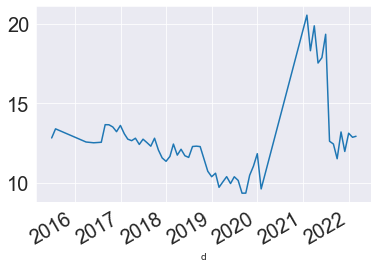

In [37]:
comp_rank_df.columns
comp_rank_df['PE'].plot()
#plt.figure(figsize=(20,10));
#plt.plot(comp_rank_df['focus_mom_rank'])

##  Save returns as pandas dataframe

In [38]:
result.to_csv("data/strategy_returns.csv")